In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [149]:
PATH_TO_DATASET = "Dataset"
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1
DEBUG = True
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [150]:
class Debug:
    enbale = False
    @staticmethod
    def setEnable(e = True):
        enbale = e
    @staticmethod
    def log(debug_msg):
        if(DEBUG):
            print(debug_msg)

In [151]:
Debug.setEnable(DEBUG)

In [152]:
dataset = tf.keras.utils.image_dataset_from_directory(PATH_TO_DATASET, batch_size=BATCH_SIZE, image_size=(IMAGE_SIZE, IMAGE_SIZE), )

Found 2152 files belonging to 3 classes.


In [153]:
n_classes = len(dataset.class_names)
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

tf.Tensor(
[[[101.  99. 112.]
  [111. 109. 122.]
  [118. 116. 129.]
  ...
  [146. 148. 161.]
  [146. 148. 161.]
  [147. 149. 162.]]

 [[130. 128. 141.]
  [130. 128. 141.]
  [121. 119. 132.]
  ...
  [146. 148. 161.]
  [147. 149. 162.]
  [148. 150. 163.]]

 [[117. 115. 128.]
  [124. 122. 135.]
  [126. 124. 137.]
  ...
  [146. 148. 161.]
  [148. 150. 163.]
  [149. 151. 164.]]

 ...

 [[124. 128. 139.]
  [113. 117. 128.]
  [104. 108. 119.]
  ...
  [181. 185. 197.]
  [179. 183. 195.]
  [182. 186. 198.]]

 [[125. 129. 140.]
  [111. 115. 126.]
  [104. 108. 119.]
  ...
  [176. 180. 192.]
  [177. 181. 193.]
  [185. 189. 201.]]

 [[124. 128. 139.]
  [121. 125. 136.]
  [128. 132. 143.]
  ...
  [175. 179. 191.]
  [178. 182. 194.]
  [189. 193. 205.]]], shape=(256, 256, 3), dtype=float32)


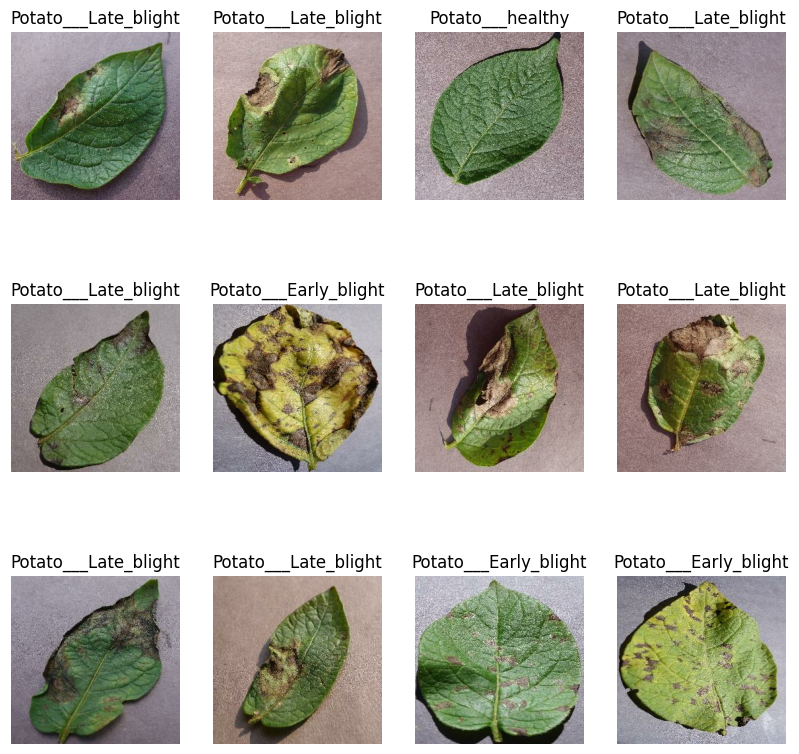

In [154]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1): # take a random batch
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch.numpy()[i].astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis("off")
    print(image_batch[i])

In [155]:
def split_dataset_tf(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = None):
    assert(train_split + test_split + val_split == 1)
    if shuffle:
        if shuffle_size is None or shuffle_size > len(ds):
            shuffle_size = int(len(ds)/10)
            Debug.log(f"Shuffle Buffer adjusted to length {shuffle_size}")
        ds = ds.shuffle(shuffle_size)
    train_ds = ds.take(int(len(ds)*train_split))
    test_ds = ds.skip(int(len(ds)*train_split))
    val_ds = test_ds.take(int(len(ds)*val_split))
    test_ds = test_ds.skip(int(len(ds)*val_split))
    return train_ds, test_ds, val_ds

In [156]:
# Test, Train, Validation Split
train_ds, test_ds, val_ds = split_dataset_tf(dataset)
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

Shuffle Buffer adjusted to length 6
54
8
6


## Preprocessing

In [157]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [158]:
resize_and_scale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(scale=1.0/255)
])

In [159]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

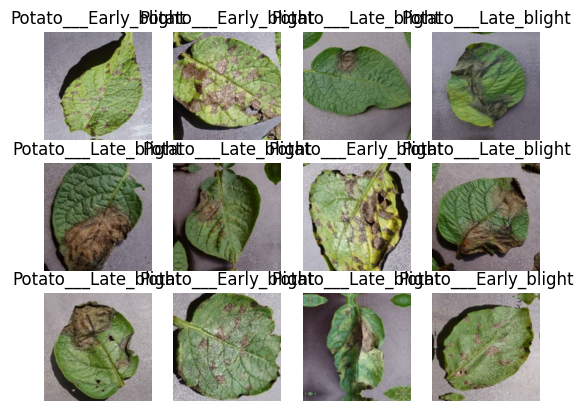

In [160]:
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch.numpy()[i].astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis("off")

## CNN Model

In [161]:
model = tf.keras.Sequential([
    resize_and_scale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

c:\Users\osman\OneDrive\Documents\Python\Deep Learning Specialization\PDC\.conda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [162]:
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_26 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling**

In [163]:
model.compile(
    optimizer='adam', 
    loss  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Fitting**

In [164]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - accuracy: 0.4562 - loss: 0.9586 - val_accuracy: 0.5104 - val_loss: 0.8472
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.5975 - loss: 0.7454 - val_accuracy: 0.7396 - val_loss: 0.5322
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.7336 - loss: 0.5242 - val_accuracy: 0.6979 - val_loss: 0.6787
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - accuracy: 0.8048 - loss: 0.4083 - val_accuracy: 0.8385 - val_loss: 0.3563
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 442ms/step - accuracy: 0.8601 - loss: 0.3265 - val_accuracy: 0.8802 - val_loss: 0.2582
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 432ms/step - accuracy: 0.8903 - loss: 0.2959 - val_accuracy: 0.8958 - val_loss: 0.2255
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 434ms/step - accuracy: 0.9335 - loss: 0.1796 - val_accuracy: 0.8490 - val_loss: 0.3802
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.9329 - loss: 0.1818 - val_accu

In [170]:
model.predict(test_ds.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


array([[9.9999988e-01, 9.0714074e-08, 8.0494760e-12],
       [1.2743007e-03, 1.2949322e-02, 9.8577636e-01],
       [1.0000000e+00, 3.1034627e-08, 1.7798040e-16],
       [3.0563102e-04, 9.9969399e-01, 3.8828952e-07],
       [3.0398081e-07, 9.9999964e-01, 8.9340237e-11],
       [9.9999869e-01, 1.2944635e-06, 3.5553771e-09],
       [1.0000000e+00, 1.3617820e-11, 2.0570520e-18],
       [9.9999976e-01, 2.8674822e-07, 1.5911430e-11],
       [1.0000000e+00, 5.7692889e-10, 4.9386298e-15],
       [9.9997318e-01, 2.6556780e-05, 2.8830794e-07],
       [2.1014911e-07, 9.9999976e-01, 5.9094946e-10],
       [9.9999726e-01, 2.7115807e-06, 6.5218381e-10],
       [2.8589040e-03, 9.9714112e-01, 8.1774667e-09],
       [9.2598362e-05, 9.9990737e-01, 3.9189825e-08],
       [1.0000000e+00, 3.6114103e-10, 2.3705752e-15],
       [9.6755123e-01, 3.2448784e-02, 2.4355705e-08],
       [1.0000000e+00, 8.5280378e-09, 2.1457974e-12],
       [9.9998164e-01, 1.8265491e-05, 8.6181146e-08],
       [1.3173019e-04, 2.115

In [183]:
np.argmax(model.predict(image_batch)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


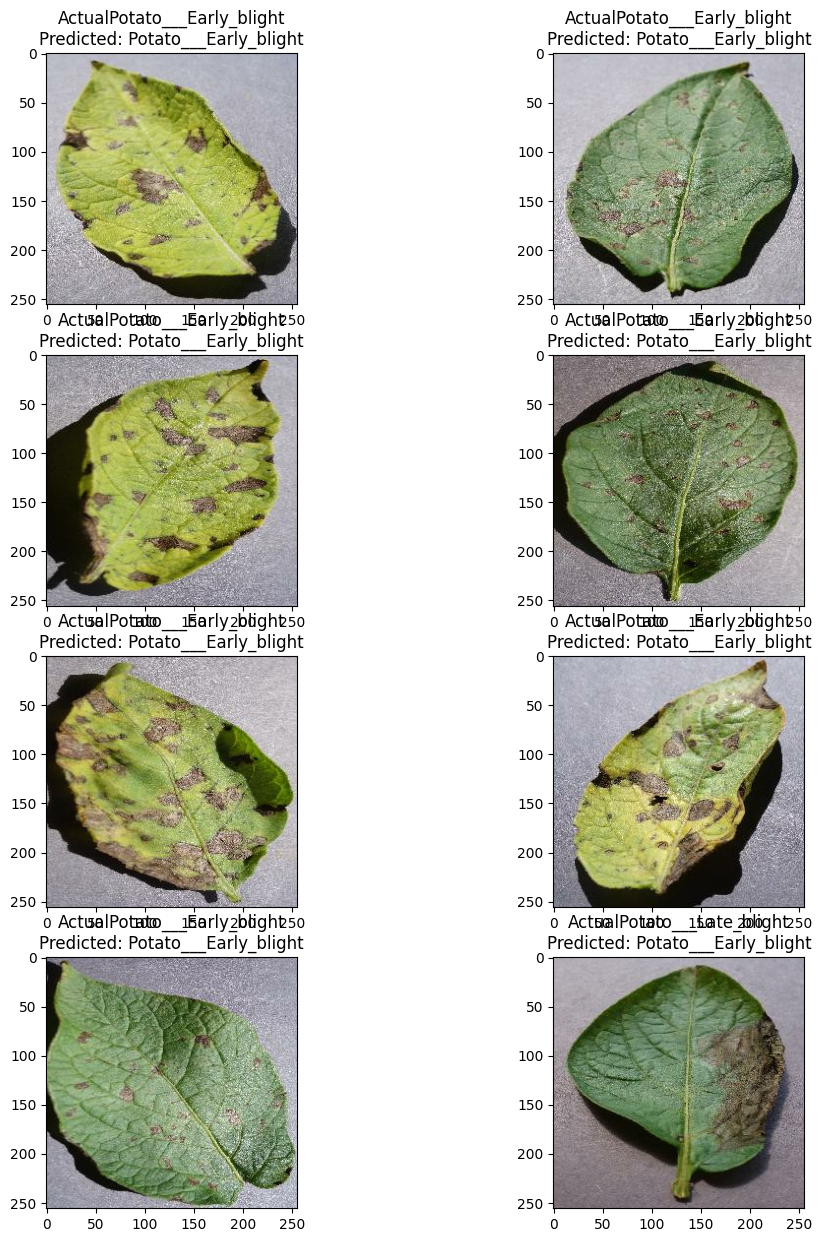

In [191]:
plt.figure(figsize=(12, 15))
for image_batch, label_batch in test_ds.take(1):
    predictions = model.predict(image_batch)
    for i in range(8):
        ax = plt.subplot(4, 2,i+1)
        plt.imshow(image_batch.numpy()[i].astype("uint8"))
        plt.title(f"Actual{dataset.class_names[label_batch[i]]}\nPredicted: {dataset.class_names[np.argmax(predictions[0])]}")

In [195]:
model.save('./saved-models/model-v1.keras')